# Assignment 5: Classification Showdown

Build and compare classification models on the Fashion-MNIST dataset.

## Setup

In [20]:
import os
import json
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    roc_auc_score,
)
from xgboost import XGBClassifier

from helpers import load_fashion_mnist, plot_roc_curves, plot_confusion_matrix

# Create output directory
OUTPUT_DIR = "output"
os.makedirs(OUTPUT_DIR, exist_ok=True)

print("Setup complete!")

Setup complete!


---

## Part 1: Binary Classification

**Task:** Classify T-shirts (label 0) vs Trousers (label 1)

This is a straightforward binary classification task. Focus on:
- Filtering data to the target classes
- Proper train/test splitting with stratification
- Scaling features correctly (fit on train only!)

In [21]:
print("Part 1: Binary Classification")

print("-" * 40)

# Load the full dataset
X, y = load_fashion_mnist()

# Filter to only labels 0 and 1
# Hint: np.isin(y, [0, 1]) returns a boolean array where True means the label is 0 or 1
# Use this mask to index into X and y: X[mask], y[mask]
mask = np.isin(y,[0,1])  # TODO: create boolean mask for labels 0 and 1
X_filtered = X[mask]  # TODO: apply mask to X
y_filtered = y[mask]  # TODO: apply mask to y

# Train/test split with stratification
# Use test_size=0.2, random_state=42, stratify=y_filtered
X_train, X_test, y_train, y_test = train_test_split(X_filtered, y_filtered, test_size=0.2, random_state=42,stratify=y_filtered) # TODO

# Scale features - fit on train, transform both
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # TODO: fit_transform on X_train
X_test_scaled = scaler.transform(X_test)   # TODO: transform X_test (not fit_transform!)

# Train LogisticRegression (use max_iter=1000, random_state=42)
model = LogisticRegression(max_iter=1000, random_state=42)  # TODO
# TODO: fit the model
model.fit(X_train_scaled, y_train)

# Evaluate
y_pred =  model.predict(X_test_scaled) # TODO: predict on X_test_scaled
print(classification_report(y_test,y_pred))

accuracy = accuracy_score(y_test, y_pred) # TODO: calculate accuracy_score
cm = confusion_matrix(y_test, y_pred)  # TODO: calculate confusion_matrix
print(cm)
# Save results
results = {
    "task": "tshirt_vs_trouser",
    "accuracy": accuracy,
    "confusion_matrix": cm.tolist()  # Convert numpy array to list for JSON
}
with open(os.path.join(OUTPUT_DIR, "part1_results.json"), "w") as f:
    json.dump(results, f, indent=2)

print(f"Accuracy: {accuracy:.4f}")
print(f"Confusion Matrix:\n{cm}")

Part 1: Binary Classification
----------------------------------------
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      1400
           1       0.98      0.99      0.98      1400

    accuracy                           0.98      2800
   macro avg       0.98      0.98      0.98      2800
weighted avg       0.98      0.98      0.98      2800

[[1371   29]
 [  17 1383]]
Accuracy: 0.9836
Confusion Matrix:
[[1371   29]
 [  17 1383]]


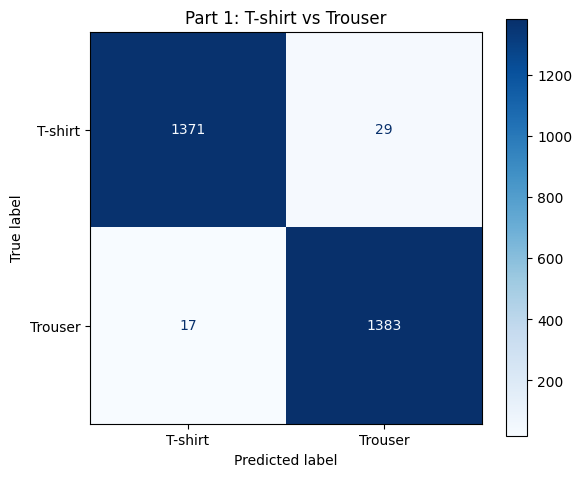

In [22]:
# Visualize results (provided - not part of assignment)
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

fig, ax = plt.subplots(figsize=(6, 5))
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['T-shirt', 'Trouser']).plot(ax=ax, cmap='Blues')
ax.set_title('Part 1: T-shirt vs Trouser')
plt.tight_layout()
plt.show()

---

## Part 2: Multi-class Classification with Cross-Validation

**Task:** Classify footwear types: Sandal (5) vs Sneaker (7) vs Ankle boot (9)

Compare three models using 5-fold cross-validation. Select the best model and evaluate on test set.

**Required outputs:**
- `output/part2_cv_results.csv` - columns: `model`, `fold`, `score`
- `output/part2_test_results.csv` - classification report as DataFrame

In [23]:
print("\nPart 2: Multi-class Classification with CV")
print("-" * 40)
# TODO: Load data, filter to labels 5, 7, 9
X, y = load_fashion_mnist()

# Filter to only include footwear and clothing samples
mask = np.isin(y, [5, 7, 9]) 
X_filtered = X[mask]
y_filtered = y[mask]
# TODO: Encode labels to 0, 1, 2 using LabelEncoder (required for XGBoost)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_filtered)
# TODO: Train/test split with stratification
X_train, X_test, y_train, y_test = train_test_split(X_filtered, y_encoded, test_size=0.2, random_state=42,stratify=y_encoded) # TODO

# TODO: Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # TODO: fit_transform on X_train
X_test_scaled = scaler.transform(X_test)   # TODO: transform X_test (not fit_transform!)

# Models to compare
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42),
    'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    'XGBoost': XGBClassifier(n_estimators=100, random_state=42, verbosity=0, n_jobs=-1)
}

# TODO: Run 5-fold CV for each model (use StratifiedKFold, scoring='accuracy')
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Compare models
cv_results = []
for name, model in models.items():
    scores = cross_val_score(model, X_train_scaled, y_train, cv=cv, scoring='accuracy')
    cv_results.append({
        'Model': name,
        'Mean_Accuracy': scores.mean(),
        'Std_Accuracy': scores.std(),
        'Scores': scores  # optional: all 5 fold scores
    })
    print(f"{name}: Accuracy = {scores.mean():.3f} (+/- {scores.std() * 2:.3f})")
# TODO: Save CV results to part2_cv_results.csv
cv_df = pd.DataFrame(cv_results)
cv_df.to_csv('output/part2_cv_results.csv', index=False)
# TODO: Find best model by mean CV score
#XGBoost had best accuracy
# TODO: Retrain best model on full training data
best_model = XGBClassifier(n_estimators=100, random_state=42, verbosity=0, n_jobs=-1)
# TODO: fit the model
best_model.fit(X_train_scaled, y_train)
# TODO: Evaluate on test set, save classification_report to part2_test_results.csv
y_pred = best_model.predict(X_test_scaled)
report = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()
report_df.to_csv('output/part2_test_results.csv')

print("\nTest Set Results:")
print(classification_report(y_test, y_pred))


Part 2: Multi-class Classification with CV
----------------------------------------
LogisticRegression: Accuracy = 0.927 (+/- 0.012)
RandomForest: Accuracy = 0.952 (+/- 0.008)
XGBoost: Accuracy = 0.967 (+/- 0.007)

Test Set Results:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1400
           1       0.95      0.97      0.96      1400
           2       0.97      0.96      0.97      1400

    accuracy                           0.97      4200
   macro avg       0.97      0.97      0.97      4200
weighted avg       0.97      0.97      0.97      4200



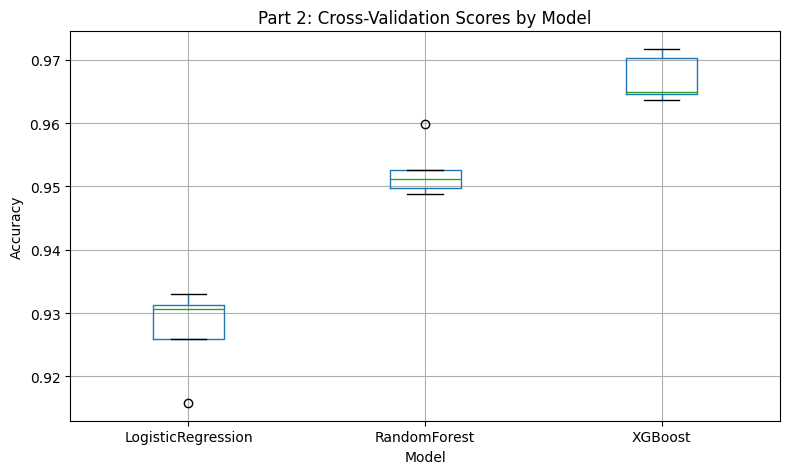

In [24]:
# Visualize CV results (provided - not part of assignment)
import matplotlib.pyplot as plt

try:
    # Reshape data for boxplot
    plot_data = []
    for result in cv_results:
        for score in result['Scores']:
            plot_data.append({'model': result['Model'], 'score': score})
    
    plot_df = pd.DataFrame(plot_data)
    
    fig, ax = plt.subplots(figsize=(8, 5))
    plot_df.boxplot(column='score', by='model', ax=ax)
    ax.set_title('Part 2: Cross-Validation Scores by Model')
    ax.set_xlabel('Model')
    ax.set_ylabel('Accuracy')
    plt.suptitle('')  # Remove automatic title
    plt.tight_layout()
    plt.show()
except NameError:
    print("cv_df not defined yet - complete the TODOs above first!")

---

## Part 3: Full Model Comparison Pipeline

**Task:** Classify Clothing vs Footwear (binary)

- **Clothing (0):** T-shirt, Trouser, Pullover, Dress, Coat, Shirt (labels 0-4, 6)
- **Footwear (1):** Sandal, Sneaker, Ankle boot (labels 5, 7, 9)
- **Exclude:** Bag (label 8)

Compare 3 models using AUC, generate ROC curves, evaluate best model.

**Required outputs:**
- `output/part3_cv_results.csv` - columns: `model`, `fold`, `auc`
- `output/part3_test_results.csv` - columns: `model`, `accuracy`, `auc`
- `output/part3_roc_curves.png` - use `plot_roc_curves()` from helpers
- `output/part3_confusion_matrix.png` - use `plot_confusion_matrix()` from helpers

In [25]:
print("\nPart 3: Full Model Comparison Pipeline")
print("-" * 40)
X, y = load_fashion_mnist()
# TODO: Load data, filter out bags (label 8)
mask = y != 8
X_filtered = X[mask]
y_filtered = y[mask]

# TODO: Create binary labels: footwear (5, 7, 9) = 1, clothing = 0
y_encoded = np.isin(y_filtered, [5, 7, 9]).astype(int)

# TODO: Train/test split with stratification
X_train, X_test, y_train, y_test = train_test_split(X_filtered, y_encoded, test_size=0.2, random_state=42,stratify=y_encoded) # TODO

# TODO: Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # TODO: fit_transform on X_train
X_test_scaled = scaler.transform(X_test)   # TODO: transform X_test (not fit_transform!)

# Models to compare
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42),
    'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    'XGBoost': XGBClassifier(n_estimators=100, random_state=42, verbosity=0, n_jobs=-1)
}

# TODO: Run 5-fold CV for all models (use StratifiedKFold, scoring='roc_auc')
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_results = []
for name, model in models.items():
    scores = cross_val_score(model, X_train_scaled, y_train, cv=cv, scoring='roc_auc')
    cv_results.append({
        'Model': name,
        'Mean_AUC': scores.mean(),
        'Std_AUC': scores.std(),
        'Scores': scores  # optional: all 5 fold scores
    })
    print(f"{name}: AUC = {scores.mean():.5f} (+/- {scores.std() * 2:.3f})")
cv_df = pd.DataFrame(cv_results)
cv_df.to_csv('output/part3_cv_results.csv', index=False)
# TODO: Save CV results to part3_cv_results.csv
# TODO: Find best model by mean AUC
#the best model is XGBoost



Part 3: Full Model Comparison Pipeline
----------------------------------------
LogisticRegression: AUC = 0.99975 (+/- 0.000)
RandomForest: AUC = 0.99999 (+/- 0.000)
XGBoost: AUC = 1.00000 (+/- 0.000)


In [26]:
# TODO: Train ALL models on full training data (needed for ROC curves)
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score

trained_models = {}
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    trained_models[name] = model
    print(f"Trained {name} on full training set")

# TODO: Generate ROC curves for ALL models together
plot_roc_curves(trained_models, X_test_scaled, y_test, 'output/part3_roc_curves.png')

# TODO: Find best model by mean AUC (from CV results)
best_model_name = cv_df.loc[cv_df['Mean_AUC'].idxmax(), 'Model']
best_model = trained_models[best_model_name]
print(f"\nBest model: {best_model_name}")

# TODO: Evaluate best model on test set (accuracy and AUC)
y_pred = best_model.predict(X_test_scaled)
y_pred_proba = best_model.predict_proba(X_test_scaled)[:, 1]  # probabilities for AUC

test_accuracy = accuracy_score(y_test, y_pred)
test_auc = roc_auc_score(y_test, y_pred_proba)

print(f"{best_model_name} Test Accuracy: {test_accuracy:.3f}")
print(f"{best_model_name} Test AUC: {test_auc:.3f}")

# TODO: Generate confusion matrix for best model
plot_confusion_matrix(y_test, y_pred, ['Clothing', 'Footwear'], 'output/part3_confusion_matrix.png')

# TODO: Save test results to CSV
test_results = pd.DataFrame([{
    'Model': best_model_name,
    'Test_Accuracy': test_accuracy,
    'Test_AUC': test_auc
}])
test_results.to_csv('output/part3_test_results.csv', index=False)

Trained LogisticRegression on full training set
Trained RandomForest on full training set
Trained XGBoost on full training set

Best model: XGBoost
XGBoost Test Accuracy: 0.999
XGBoost Test AUC: 1.000


---

## Validation

In [27]:
# Run in terminal: pytest .github/tests/ -v
print("Run 'pytest .github/tests/ -v' in your terminal to check your work.")

Run 'pytest .github/tests/ -v' in your terminal to check your work.
